# TASK 1

QUESTION 1.1

In [1]:
# Load and preprocess datasets
import re
from collections import Counter
import requests

# Replace with your actual dataset URLs
natural_url = "https://www.gutenberg.org/files/1661/1661-0.txt"
structured_url = "https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt"

def load_text(url):
    return requests.get(url).text

def preprocess_text(text, structured=False):
    lines = text.split('\n') if structured else re.split(r'\.|\n', text)
    tokens = []
    for line in lines:
        line = line.lower()
        if not structured:
            line = re.sub('[^a-zA-Z0-9 \.]', '', line)
        tokens.extend(line.strip().split())
    return tokens

# Load and preprocess
tokens_nat = preprocess_text(load_text(natural_url), structured=False)
tokens_struct = preprocess_text(load_text(structured_url), structured=True)

# Build vocabulary
def build_vocab(tokens):
    vocab = sorted(set(tokens))
    word_to_idx = {w: i for i, w in enumerate(vocab)}
    idx_to_word = {i: w for w, i in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

vocab_nat, w2i_nat, i2w_nat = build_vocab(tokens_nat)
vocab_struct, w2i_struct, i2w_struct = build_vocab(tokens_struct)

# Report
def report_freq(tokens):
    counter = Counter(tokens)
    print("Vocabulary size:", len(set(tokens)))
    print("Most frequent:", counter.most_common(10))
    print("Least frequent:", counter.most_common()[:-11:-1])

print("Natural Language Dataset:")
report_freq(tokens_nat)

print("\nStructured Dataset:")
report_freq(tokens_struct)


<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1852361203.py:19: SyntaxWarning: invalid escape sequence '\.'
  line = re.sub('[^a-zA-Z0-9 \.]', '', line)


Natural Language Dataset:
Vocabulary size: 8683
Most frequent: [('the', 5811), ('and', 3066), ('i', 2994), ('of', 2779), ('to', 2763), ('a', 2683), ('in', 1818), ('that', 1750), ('it', 1710), ('you', 1548)]
Least frequent: [('newsletter', 1), ('subscribe', 1), ('includes', 1), ('pg', 1), ('edition', 1), ('necessarily', 1), ('network', 1), ('originator', 1), ('hart', 1), ('michael', 1)]

Structured Dataset:
Vocabulary size: 111118
Most frequent: [('*', 33504), ('=', 28003), ('if', 18989), ('{', 18915), ('the', 17488), ('}', 16965), ('*/', 13445), ('/*', 12190), ('struct', 10997), ('return', 10274)]
Least frequent: [('context_tracking_init(void)', 1), ('config_context_tracking_force', 1), ('set_tsk_thread_flag(next,', 1), ('clear_tsk_thread_flag(prev,', 1), ('__context_tracking_task_switch(struct', 1), ('tif', 1), ('syscalls.', 1), ('user-kernel', 1), ('__context_tracking_task_switch', 1), ('nokprobe_symbol(context_tracking_user_exit);', 1)]


QUESTION 1.2

Epoch 000 | Train Loss: 6.442449 | Val Loss: 6.197770 | Val Acc: 0.0921
Epoch 001 | Train Loss: 5.944504 | Val Loss: 6.052333 | Val Acc: 0.1033
Epoch 002 | Train Loss: 5.631247 | Val Loss: 6.038450 | Val Acc: 0.1101
Epoch 003 | Train Loss: 5.375336 | Val Loss: 6.068858 | Val Acc: 0.1148
Epoch 004 | Train Loss: 5.146654 | Val Loss: 6.101497 | Val Acc: 0.1155
Epoch 005 | Train Loss: 4.937812 | Val Loss: 6.180753 | Val Acc: 0.1179
Epoch 006 | Train Loss: 4.743671 | Val Loss: 6.267081 | Val Acc: 0.1170
Epoch 007 | Train Loss: 4.445392 | Val Loss: 6.358607 | Val Acc: 0.1200
Epoch 008 | Train Loss: 4.266675 | Val Loss: 6.484203 | Val Acc: 0.1204
Epoch 009 | Train Loss: 4.122522 | Val Loss: 6.565978 | Val Acc: 0.1178
Early stopping at epoch 9 (no improvement in 7 epochs).


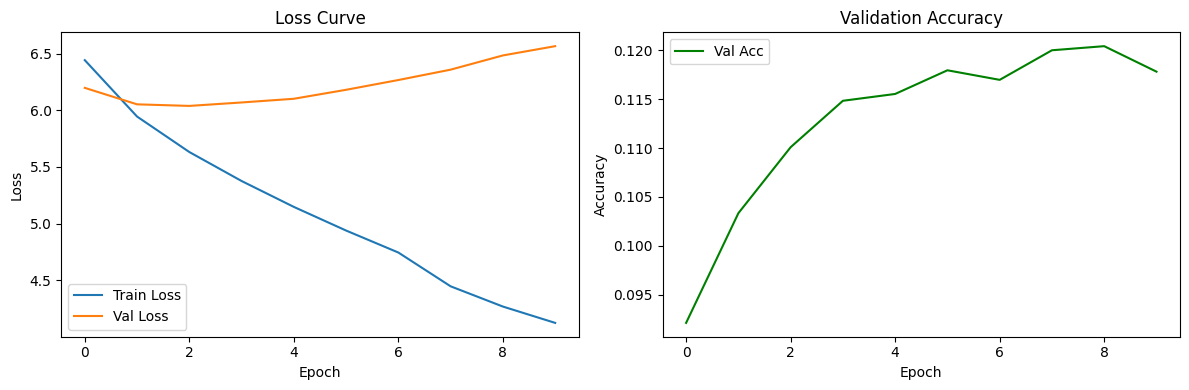

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import random

# Step 1: Create dataset
def create_dataset(tokens, word_to_idx, context_len=5):
    X, y = [], []
    for i in range(len(tokens) - context_len):
        context = tokens[i:i+context_len]
        target = tokens[i+context_len]
        if all(w in word_to_idx for w in context + [target]):
            X.append([word_to_idx[w] for w in context])
            y.append(word_to_idx[target])
    return torch.tensor(X), torch.tensor(y)

# Step 2: Define MLP model
class MLPTextGen(nn.Module):
    def __init__(self, vocab_size, context_len=5, emb_dim=64, hidden_dims=[1024],
                 activation='relu', dropout=0.3):
        super().__init__()
        self.context_len = context_len
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        layers = []
        input_dim = emb_dim * context_len
        act_fn = nn.ReLU if activation=='relu' else nn.Tanh

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(act_fn())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, vocab_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)
        return self.net(x)

# Step 3: Train model with validation, early stopping & saturation
def train_model(X, y, vocab_size, context_len=5, emb_dim=64, hidden_dims=[1024],
                activation='relu', epochs=100, val_split=0.2, patience=7,
                dropout=0.3, clip_grad=1.0, saturation_thresh=1e-5):

    dataset = TensorDataset(X, y)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    generator = torch.Generator().manual_seed(random.randint(0, 9999))
    train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=128)

    model = MLPTextGen(vocab_size, context_len, emb_dim, hidden_dims, activation, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses, val_accs = [], [], []
    recent_val_losses = []

    for epoch in range(epochs):
        # Train
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                logits = model(xb)
                loss = criterion(logits, yb)
                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        # Scheduler
        scheduler.step(avg_val_loss)

        # Print
        print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val Acc: {val_acc:.4f}")
        if avg_val_loss < best_val_loss - 1e-5:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch} (no improvement in {patience} epochs).")
                break
        # Saturation detection
        recent_val_losses.append(avg_val_loss)
        if len(recent_val_losses) > patience:
            recent_val_losses.pop(0)
            if max(recent_val_losses) - min(recent_val_losses) < saturation_thresh:
                print(f"Model saturated at epoch {epoch} (val loss change < {saturation_thresh}).")
                break

    return model, train_losses, val_losses, val_accs

# Step 4: Plot metrics
def plot_metrics(train_losses, val_losses, val_accs):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")
    plt.subplot(1,2,2)
    plt.plot(val_accs, label="Val Acc", color="green")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

# Step 5: Run training
context_len = 5
X_nat, y_nat = create_dataset(tokens_nat, w2i_nat, context_len)
model_nat, train_losses, val_losses, val_accs = train_model(
    X_nat, y_nat,
    vocab_size=len(vocab_nat),
    context_len=context_len,
    emb_dim=64,
    hidden_dims=[1024, 1024],
    activation='relu',
    epochs=100,
    dropout=0.3,
    saturation_thresh=1e-5
)
plot_metrics(train_losses, val_losses, val_accs)


In [38]:
print(len(X_nat))
print(len(vocab_nat))

107604
8683


In [3]:
torch.save(model_nat.state_dict(), "model_sherlock.pt")

Dataset size: 38047 samples, Vocab size: 8869
Epoch 000 | Train: 7.05816 | Val: 6.71135 | Acc: 0.1238
Epoch 001 | Train: 6.21250 | Val: 6.54527 | Acc: 0.1442
Epoch 002 | Train: 5.62340 | Val: 6.46118 | Acc: 0.1559
Epoch 003 | Train: 5.10402 | Val: 6.48269 | Acc: 0.1736
Epoch 004 | Train: 4.63343 | Val: 6.55259 | Acc: 0.1856
Epoch 005 | Train: 4.18262 | Val: 6.73107 | Acc: 0.1950
Epoch 006 | Train: 3.72914 | Val: 6.95841 | Acc: 0.1979
Epoch 007 | Train: 3.30903 | Val: 7.18937 | Acc: 0.1970
Epoch 008 | Train: 2.88199 | Val: 7.59159 | Acc: 0.2054
Epoch 009 | Train: 2.35297 | Val: 7.93540 | Acc: 0.2041
Epoch 010 | Train: 2.03841 | Val: 8.11317 | Acc: 0.2095
Epoch 011 | Train: 1.76533 | Val: 8.62926 | Acc: 0.2128
Epoch 012 | Train: 1.53419 | Val: 9.01997 | Acc: 0.2126
Epoch 013 | Train: 1.34314 | Val: 9.45076 | Acc: 0.2126
Epoch 014 | Train: 1.18281 | Val: 9.65072 | Acc: 0.2109
Epoch 015 | Train: 0.96966 | Val: 9.90393 | Acc: 0.2197
Epoch 016 | Train: 0.87646 | Val: 10.07472 | Acc: 0.2209
E

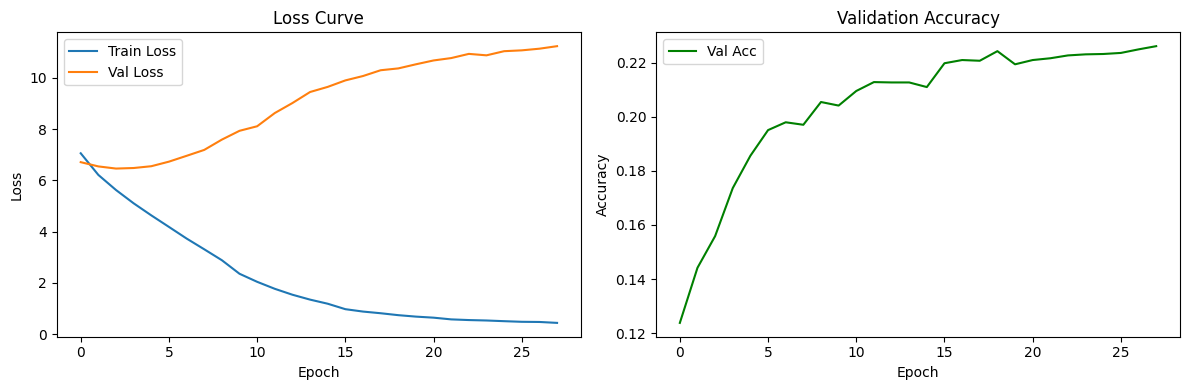

Model saved as mlp_cpp_dataset.pt


In [43]:

import re
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import random
import requests

# Step 0: Load and preprocess Linux/C++ dataset
cpp_url = "https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt"
cpp_text = requests.get(cpp_url).text

def preprocess_structured_code(text):
    lines = text.split("\n")
    tokens = []
    for line in lines:
        line = line.strip()
        if line:
            tokens.extend(line.split())  # split by whitespace
    return tokens

tokens_struct = preprocess_structured_code(cpp_text[:300000])

# Step 1: Build vocabulary
def build_vocab(tokens):
    vocab = sorted(set(tokens))
    w2i = {w: i for i, w in enumerate(vocab)}
    i2w = {i: w for w, i in w2i.items()}
    return vocab, w2i, i2w

vocab_struct, w2i_struct, i2w_struct = build_vocab(tokens_struct)

# Step 2: Create dataset
def create_dataset(tokens, word_to_idx, context_len=5):
    X, y = [], []
    for i in range(len(tokens) - context_len):
        context = tokens[i:i+context_len]
        target = tokens[i+context_len]
        if all(w in word_to_idx for w in context + [target]):
            X.append([word_to_idx[w] for w in context])
            y.append(word_to_idx[target])
    return torch.tensor(X), torch.tensor(y)

context_len = 5
X_cpp, y_cpp = create_dataset(tokens_struct, w2i_struct, context_len)
print(f"Dataset size: {len(X_cpp)} samples, Vocab size: {len(vocab_struct)}")

# Step 3: Define MLP model
class MLPTextGen(nn.Module):
    def __init__(self, vocab_size, context_len=5, emb_dim=64, hidden_dims=[1024, 1024],
                 activation='relu', dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        layers = []
        input_dim = emb_dim * context_len
        act_fn = nn.ReLU if activation=='relu' else nn.Tanh

        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(act_fn())
            layers.append(nn.Dropout(dropout))
            input_dim = h_dim

        layers.append(nn.Linear(input_dim, vocab_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)
        return self.net(x)

# Step 4: Train model
def train_model(X, y, vocab_size, context_len=5, emb_dim=64, hidden_dims=[1024, 1024],
                activation='relu', epochs=150, val_split=0.2, patience=25,
                dropout=0.3, clip_grad=1.0, saturation_thresh=1e-6, batch_size=64):

    dataset = TensorDataset(X, y)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = MLPTextGen(vocab_size, context_len, emb_dim, hidden_dims, activation, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses, val_accs = [], [], []
    recent_val_losses = []

    for epoch in range(epochs):
        # Train
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                logits = model(xb)
                loss = criterion(logits, yb)
                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch:03d} | Train: {avg_train_loss:.5f} | Val: {avg_val_loss:.5f} | Acc: {val_acc:.4f}")

        # Early stopping + saturation
        if avg_val_loss < best_val_loss - 1e-5:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        recent_val_losses.append(avg_val_loss)
        if len(recent_val_losses) > patience:
            recent_val_losses.pop(0)
            if max(recent_val_losses) - min(recent_val_losses) < saturation_thresh:
                print(f"Model saturated at epoch {epoch}")
                break

    return model, train_losses, val_losses, val_accs

# Step 5: Train and Save
model_cpp, train_losses_cpp, val_losses_cpp, val_accs_cpp = train_model(
    X_cpp, y_cpp,
    vocab_size=len(vocab_struct),
    context_len=context_len,
    emb_dim=64,
    hidden_dims=[1024, 1024],
    activation='relu',
    epochs=150,
    dropout=0.3
)

# Step 6: Plot metrics
def plot_metrics(train_losses, val_losses, val_accs):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")
    plt.subplot(1,2,2)
    plt.plot(val_accs, label="Val Acc", color="green")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

plot_metrics(train_losses_cpp, val_losses_cpp, val_accs_cpp)

# Step 7: Save model
torch.save(model_cpp.state_dict(), "mlp_cpp_dataset.pt")
print("Model saved as mlp_cpp_dataset.pt")


In [44]:
print(f"Dataset size: {len(X_cpp)} samples, Vocab size: {len(vocab_struct)}")

Dataset size: 38047 samples, Vocab size: 8869


In [47]:
# Next-token prediction function
def predict_next(model, seed_tokens, w2i, i2w, ctx_len=5, k=10, temperature=1.0):
    model.eval()
    unk = w2i.get('<unk>', 0)
    out = seed_tokens[:]
    device = next(model.parameters()).device

    for _ in range(k):
        x_indices = [w2i.get(w, unk) for w in out[-ctx_len:]]
        if len(x_indices) < ctx_len:
            x_indices = [unk]*(ctx_len-len(x_indices)) + x_indices
        x = torch.tensor([x_indices], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(x)[0]
            probs = torch.softmax(logits/temperature, dim=0)
            idx = torch.multinomial(probs, 1).item()
        out.append(i2w[idx])
    return out

# Sherlock-themed seed examples
sherlock_seeds = [
    ["sherlock", "holmes", "was", "in", "his"],
    ["dr", "watson", "followed", "the", "detective"],
    ["it", "was", "a", "dark", "and"],
    ["the", "murder", "took", "place", "at"]
]

# Generate predictions
for seed in sherlock_seeds:
    next_tokens = predict_next(model_nat, seed, w2i_nat, i2w_nat, ctx_len=context_len, k=15, temperature=0.8)
    print("Seed:", seed)
    print("-->")
    print("Generated:", next_tokens)


cpp_seeds = [
    ["if", "(", "x", ">", "0"],
    ["while", "(", "i", "<", "n"],
    ["return", "0", ";", "}"],
    ["for", "(", "int", "i", "="],
    ["cout", "<<", "\"Hello\"", ";"]
]

# Generate predictions
for seed in cpp_seeds:
    next_tokens = predict_next(model_cpp, seed, w2i_struct, i2w_struct, ctx_len=5, k=15, temperature=0.8)
    print("Seed:", seed)
    print("-->")
    print("Generated:", " ".join(next_tokens))
    print()



Seed: ['sherlock', 'holmes', 'was', 'in', 'his']
-->
Generated: ['sherlock', 'holmes', 'was', 'in', 'his', 'dress', 'i', 'am', 'us', 'to', 'give', 'me', 'your', 'new', 'among', 'in', 'a', 'sheet', 'on', 'work']
Seed: ['dr', 'watson', 'followed', 'the', 'detective']
-->
Generated: ['dr', 'watson', 'followed', 'the', 'detective', 'star', 'to', 'what', 'it', 'must', 'have', 'been', 'any', 'remarked', 'you', 'would', 'think', 'that', 'ill', 'before']
Seed: ['it', 'was', 'a', 'dark', 'and']
-->
Generated: ['it', 'was', 'a', 'dark', 'and', 'tossed', 'a', 'cheetah', 'note', 'near', 'smoke', 'in', 'any', 'way', 'mr', 'sherlock', 'holmes', 'was', 'remained', 'the']
Seed: ['the', 'murder', 'took', 'place', 'at']
-->
Generated: ['the', 'murder', 'took', 'place', 'at', 'the', 'line', 'of', 'this', 'agreement', 'it', 'said', 'he', 'the', 'street', 'he', 'had', 'brought', 'upon', 'the']
Seed: ['if', '(', 'x', '>', '0']
-->
Generated: if ( x > 0 { if (first) == 0) return 1; return 0; } static int pos

QUESTION 1.3

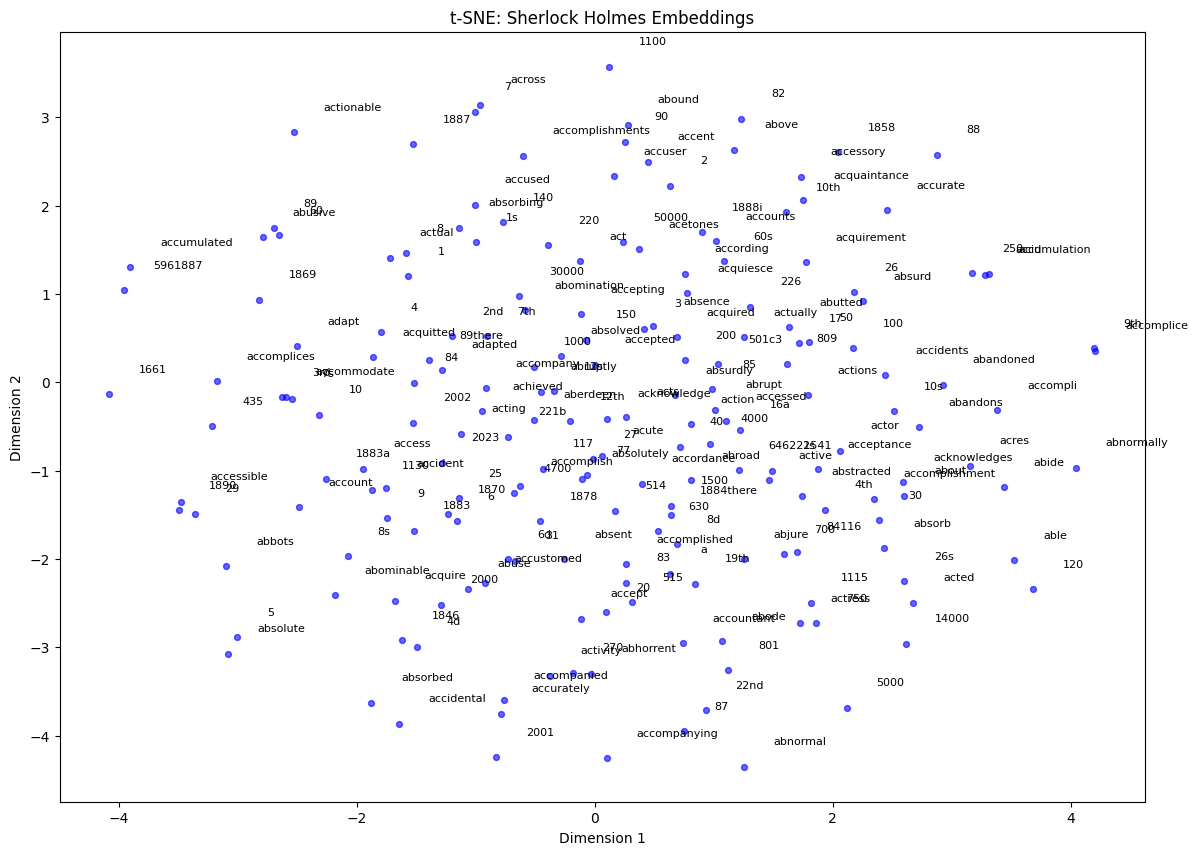

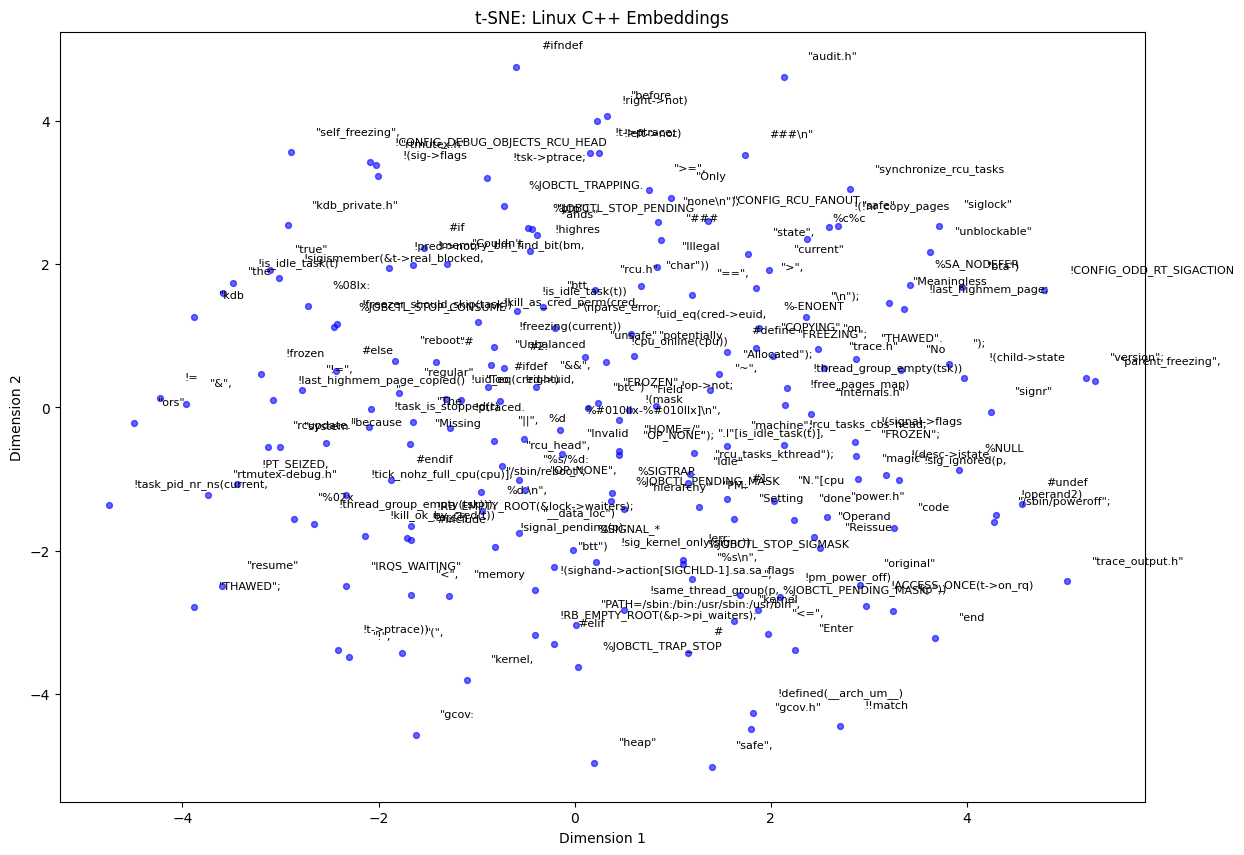

In [46]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings(model, i2w, max_words=None, perplexity=30, title="t-SNE Embeddings"):
    emb = model.embedding.weight.detach().cpu().numpy()
    if max_words:
        emb = emb[:max_words]
        words = [i2w[i] for i in range(max_words)]
    else:
        words = [i2w[i] for i in range(len(i2w))]
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, init='pca')
    reduced = tsne.fit_transform(emb)
    plt.figure(figsize=(14, 10))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=18, color='blue', alpha=0.6)
    for i, word in enumerate(words):
        plt.text(reduced[i, 0] + 0.25, reduced[i, 1] + 0.25, word, fontsize=8)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

visualize_embeddings(model_nat, i2w_nat, max_words=200, title="t-SNE: Sherlock Holmes Embeddings")
visualize_embeddings(model_cpp, i2w_struct, max_words=200, title="t-SNE: Linux C++ Embeddings")


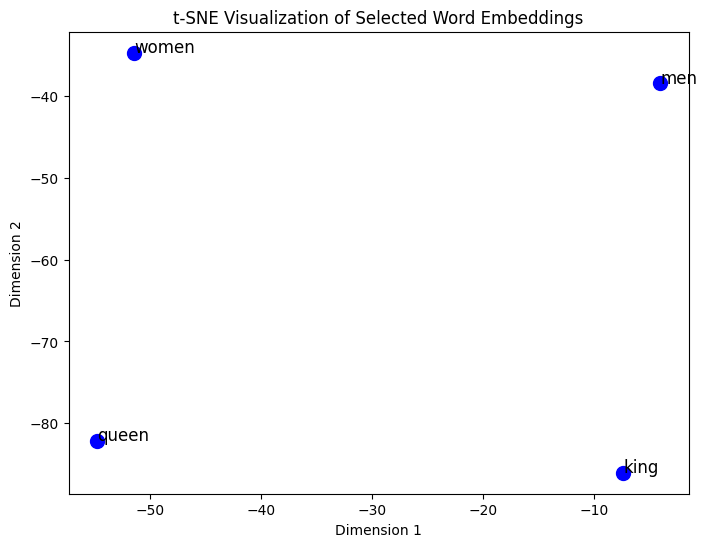

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings(model, word_to_idx, words_to_plot=["king","queen","men","women"]):
    # Filter words that exist in vocabulary
    words_to_plot = [w for w in words_to_plot if w in word_to_idx]
    if len(words_to_plot) == 0:
        raise ValueError("None of the selected words exist in the vocabulary!")

    # Get indices and embeddings
    indices = [word_to_idx[w] for w in words_to_plot]
    emb = model.embedding.weight.detach().cpu().numpy()
    selected_emb = emb[indices]  # shape: (num_words, emb_dim)

    # t-SNE to 2D
    tsne = TSNE(n_components=2, perplexity=3, random_state=42)
    reduced = tsne.fit_transform(selected_emb)

    # Plot
    plt.figure(figsize=(8,6))
    for i, word in enumerate(words_to_plot):
        x, y = reduced[i]
        plt.scatter(x, y, s=100, color='blue')
        plt.text(x+0.05, y+0.05, word, fontsize=12)
    plt.title("t-SNE Visualization of Selected Word Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Example usage
visualize_embeddings(model_nat, w2i_nat, ["king","queen","men","women"])


QUESTION 1.4

Implemented in VS code

In [9]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 111.8 MB/s eta 0:00:00


In [25]:
import json

# Example for Sherlock dataset
with open("stoi.json", "w") as f:
    json.dump(vocab_nat, f)

with open("itos.json", "w") as f:
    json.dump(i2w_nat, f)


In [68]:
from google.colab import files

# Replace with your filenames
files_to_download = ["stoi.json", "itos.json", "model_sherlock.pt", "mlp_cpp_dataset.pt"]

for f in files_to_download:
    files.download(f)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
!ls

app.py	   mlp_cpp_dataset.pt  model_sherlock.pt  stoi.json
itos.json  mlp_linux.pt        sample_data


QUESTION 1.5

The two MLP models trained on natural language (Sherlock Holmes text) and structured data (Linux code) show clear differences in data complexity and learnability. The natural dataset had about 107K samples and 8.6K vocabulary, while the structured dataset had 38K samples and a similar vocab size. Natural language is semantically rich and less predictable, whereas code is highly structured and repetitive.

The natural language model showed a gradual decrease in training loss (6.44 → 4.12) and a modest rise in validation loss, indicating mild overfitting, with validation accuracy around 12%. The Linux dataset model trained faster (loss 7.05 → 0.47) and reached a higher validation accuracy of about 22%, but its validation loss increased after early epochs, suggesting stronger overfitting.

Embedding visualizations also differed — the natural model grouped words with semantic similarity (like names or verbs), while the structured model clustered syntactic tokens (if, while, return). Generated text from the natural model was more linguistically coherent, while the Linux model produced syntactically correct but less varied code snippets.

Overall, structured language is easier for the MLP to learn due to its predictable syntax, while natural language requires deeper contextual understanding, making it harder to model effectively.